이 노트북은 2가지 노트북을 종합해서 만들었습니다.
- EDA 및 전체적인 구조: [Twitter sentiment Extaction-Analysis,EDA and Model](https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model) 
  - 해당 dataset 에서 Most vote 를 받은 notebook 입니다.
- 모델 사용(Tensorflow): [TensorFlow roBERTa - [0.705]](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705)
  - 저는 Tensorflow 에 익숙한데, 특히 점수가 괜찮아보이고, 특정 모델을 사용한 것으로 보여 이 notebook 을 선택했습니다.

Data 로는 총 3가지를 사용합니다. 오른쪽의 + Add data 에 다음과 같은 3개를 등록하세요.
* tweet-sentiment-extraction
* tf-roberta
* tse-spacy-model

추가하거나 업데이트된 내용은 따로 표시할 수 있도록 해보겠습니다.

# 참고자료

**[Twitter sentiment Extaction-Analysis,EDA and Model](https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model)**
* https://www.kaggle.com/aashita/word-clouds-of-various-shapes
  * WORDCLOUDS FUNCTION: 다양한 글자들을 특정 이미지의 형태로 만들어 표현하는 기법으로 멋진 그림을 위해서 사용합니다.
* https://www.kaggle.com/rohitsingh9990/ner-training-using-spacy-0-628-lb 
  * For understanding how to train spacy NER on custom inputs
    
**[TensorFlow roBERTa - [0.705]](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705)**
* https://www.kaggle.com/abhishek/roberta-inference-5-folds
  * Tokenization logic 을 빌려왔다고 합니다.
* roBERTa 논문은 BERT 를 '잘' 학습시킴으로써 BERT 이후에 나온 work 들 보다 다양한 finetuning job 들에서 좋은 성능을 보일 수 있음을 보여주었습니다. 아래는 roBERTa 논문의 4장에 실린 실험 내용들을 가져온 것들입니다.
  * Static vs. Dynamic Masking 실험: MLM 의 특성을 잘 살려서 미리 같은 곳만 masking 을 하지 않고 on-the-fly 로 dynamic 하게 input masking 을 합니다.
  * Model Input Format and Next Sentence Prediction: NSP(Next Sentence Prediction) 를 objective 로 사용했을때 성능이 좋아지지 않음을 보여주며, Segment-pair, sentence-pair, full-sentences, doc-sentences 들의 방법을 통해서 Sentence 를 어떻게 잘 모아서 학습을 시켰을때 성능이 좋아지는 지 보여줍니다. 결론적으로 가장 좋은 성능은 NSP 를 사용하지 않으며, 같은 Document 의 문장들만 잘 모아서 학습시켰을때가 좋은 결과를 냈습니다.
  * Training with large batches: Batch 사이즈를 2K, 8K 등과 같이 엄청 크게 만들어줍니다.
  * Text Encoding: 기존 BERT 에서는 char-level 의 BPE 을 사용하며 30k 의 vocab 을 사용했지만, roBERTa 에서는 50k byte-level BPE 를 사용했으며, 추가적인 input 에 대한 tokenization 이나 preprocessing 을 하지 않았다고 합니다.
  * 또한 5장에서는 BERT-large 에서 사용한 13GB 데이터셋보다 훨씬 큰 496GB 정도의 학습 데이터셋을 각각 8K batch로 500K step 까지 학습시킴으로써 성능 향상을 이룬 방법입니다.

# 목적

이 노트북을 통해서 저는 다음과 같은 목적을 이루고자 합니다.
- EDA 를 통한 데이터셋 이해하기.
  - 데이터 셋 분석을 위한 시각화. (matplotlib, seaborn, plotly, word cloud)
  - 데이터셋의 분포 분석.
- Tensorflow 모델인 roBERTa 를 통해서 학습을 시켜보기.

# 필요한 패키지들을 import 합니다.

[PEP8](https://www.python.org/dev/peps/pep-0008/) 참고
* import 는 한 줄씩 적어야 한다.
* 파일의 맨 위에 import 를 적어야 한다.
* python 패키지를 import 할때는 총 3가지로 그룹핑해야 한다.
  * python 의 standard library
  * third_party library
  * 로컬(Local application/library) 에서 가져올 패키지들
* wild import 는 쓰지 말아야 한다.

이건 현업에서만 해당할 수 있지만, 보통은 각 그룹별로 a->z 를 시켜서 씁니다.

In [1]:
# standard library
import collections
import os
import random
import re
import string
import tqdm
import warnings
warnings.filterwarnings("ignore")

# third-party library
import matplotlib.pyplot as plt
import nltk.corpus # stopwords
import numpy as np 
import pandas as pd 
from PIL import Image
from plotly import graph_objs, express, figure_factory  # go. pe, ff
import seaborn as sns
import spacy.util # compounding, minibatch
import tensorflow as tf
import tokenizers
import transformers
from sklearn.model_selection import StratifiedKFold
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

In [2]:
print('TF version', tf.__version__)

TF version 2.1.0


랜덤 컬러를 만들 수 있도록 하는 함수를 제공해주고자 하네요.

In [3]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# 데이터 읽기

kaggle 에서는 보통 데이터를 처리하기 위해서 pandas library 를 사용합니다.

In [106]:
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
ss = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [5]:
# row 수, col 수 라고 생각하시면 됩니다.
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


27481 개의 train set, 3534 개의 test set 을 제공하네요.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
textID           27481 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27481 non-null object
dtypes: object(4)
memory usage: 858.9+ KB


1개에 대해서 text, selected_text 가 null 이 존재하니까 없애줍니다.

In [7]:
train.dropna(inplace=True)

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
textID       3534 non-null object
text         3534 non-null object
sentiment    3534 non-null object
dtypes: object(3)
memory usage: 83.0+ KB


test 셋은 괜찮네요.

# EDA

[EDA](https://www.itl.nist.gov/div898/handbook/eda/section1/eda11.htm) 란 Exploratory Data Analysis 의 줄임말입니다. 데이터 셋에 대한 insight 를 가지기 위해서 데이터는 분석하는 방법입니다.
* 데이터 셋에 대해서 insight 를 최대화 하고
* 데이터 셋의 생김새에 대해서 알아내며
* 중요한 변수를 찾아서 추출해내고
* outlier 나 anomalies 를 발견해내고
* 예상에 대한 테스트를 해보며
* 굉장히 검소한 모델(parsimonious model)을 만들고
* optimal factor 를 만들어내는 과정이라고 합니다.

검소한 모델을 'explain data with a minimum number of parameters, or predictor variables' 라고 말하고 있네요. 하지만 우리는 tensorflow 의 keras 를 사용할 것이라... EDA 에서 데이터 분석만을 하고 넘어가겠습니다!

In [9]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


selected_text 열은 text 열의 substring 인것 같습니다.

In [10]:
len(train.apply(lambda x: x.selected_text in x.text, axis=1))

27480

In [11]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,f80acffa84,"after a great day at work with the kids, disap...",good,neutral
freq,1,1,199,11117


sentiment 의 distribution 을 봅시다.

In [12]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


생각보다 많은 것들이 neutral 값을 가지고 있습니다.

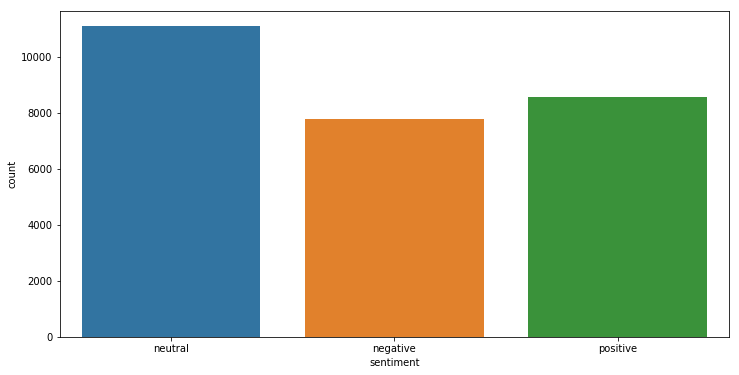

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

Funnel-Chart 로 보면 더 확실하게 보입니다.

In [14]:
fig = graph_objs.Figure(graph_objs.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

## 데이터를 보고 알게된 것들

* 우리는 selected_text 가 text 의 subset 이라는 것을 보았습니다.
* 우리는 selected_text 가 연속된 단어로부터 생성되었음을 알았습니다. 여러 문장에서 일부분씩 추출되지는 않음을 볼 수 있습니다.
* https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/138520 를 보면 neutral tweet 은 selected_text 와 text 간의 jaccard similarity 가 97% 라고 합니다.
* https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/138272 를 보면 selected_text 가 단어 사이에서 시작하는 경우가 종종 있어서 항상 말이 되는건 아니며, 테스트 셋에서도 이것이 유효한지는 잘 모르기 때문에 문장을 preprocessing 하거나 punctuation 을 없애는게 좋은 솔루션인지 알 수 없다고 합니다.

## Meta-Feature 만들기

다음과 같은 두 가지 정보를 사용하면 더 좋은 결과를 낼 수 있을 거라고 합니다.
* text 와 selected_text 사이의 단어 숫자 차이
* text 와 selected_text 사이의 jaccard similarity score.

[jaccard similiarity](https://www.geeksforgeeks.org/find-the-jaccard-index-and-jaccard-distance-between-the-two-given-sets/)는 다음과 같이 계산될 수 있다고 합니다.

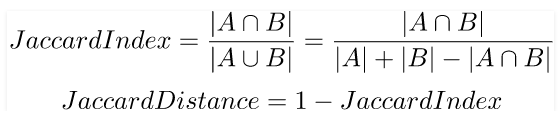

In [15]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [16]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [17]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [18]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [19]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


Meta-Features 의 distribution 을 살펴봅시다.

In [20]:
train.describe()

,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
count,27480.000000,27480.000000,27480.000000,27480.000000
mean,0.589076,7.102511,12.902875,5.800364
std,0.411319,6.891179,6.925938,7.249036
min,0.000000,1.000000,1.000000,0.000000
25%,0.142857,1.000000,7.000000,0.000000
50%,0.666667,4.000000,12.000000,2.000000
75%,1.000000,11.000000,18.000000,11.000000
max,1.000000,33.000000,33.000000,31.000000


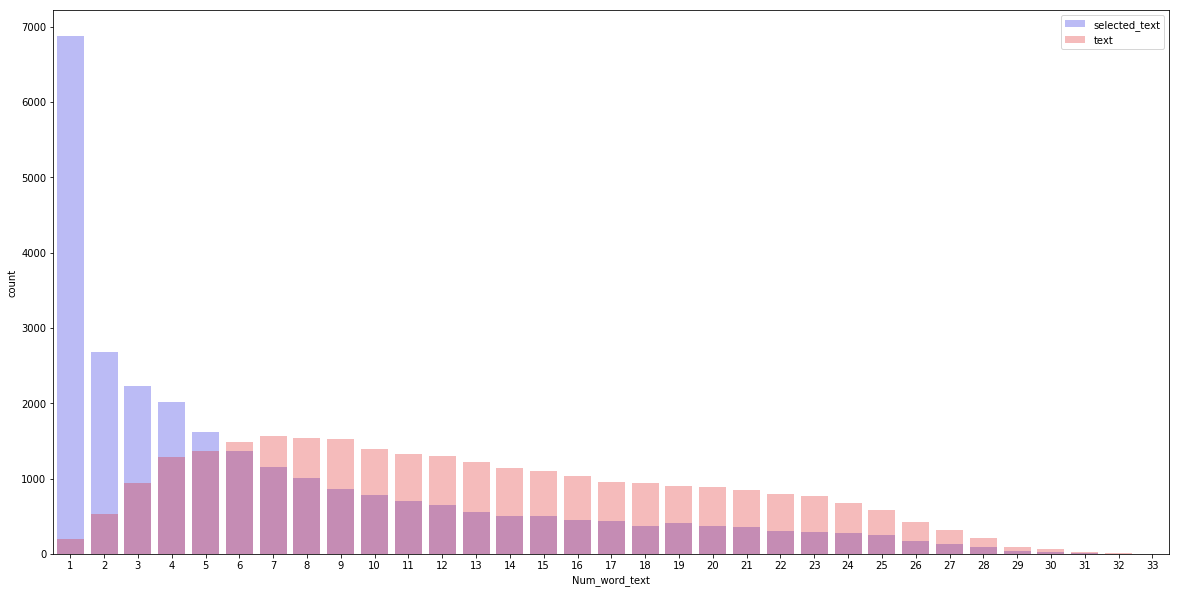

In [21]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig, axes = plt.subplots(figsize=(20,10))
sns.countplot(train['Num_words_ST'], ax=axes, color='blue', alpha=0.3, label='selected_text')
sns.countplot(train['Num_word_text'], ax=axes, color='red', alpha=0.3, label='text')
axes.legend()
fig.show()

Sentiment 별로 데이터들을 살펴봅시다.

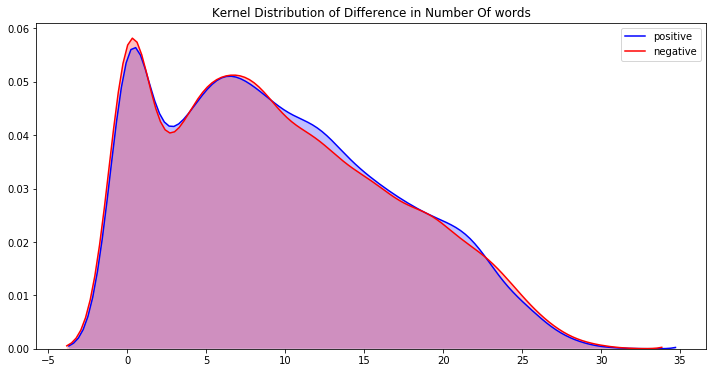

In [22]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b", label='positive').set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r",label='negative')

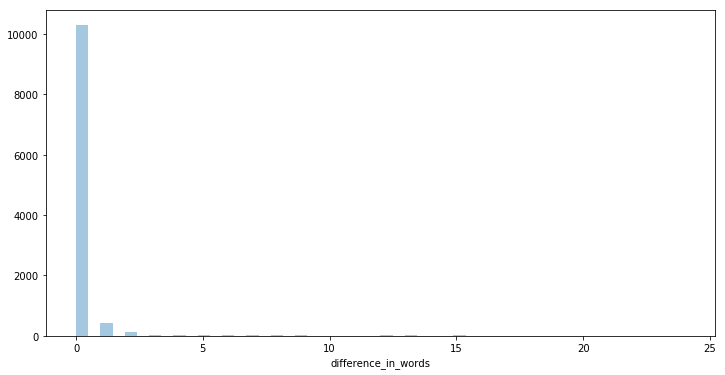

In [23]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

그림에서 볼 수 있듯이 neutral 에 대해서는 차이가 거의 없음을 볼 수 있었습니다. 이는 jaccard_score 를 확인하면 더 잘 알 수 있습니다.

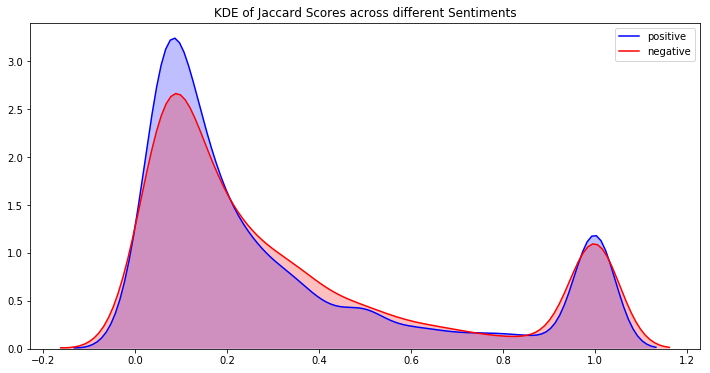

In [24]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b", label='positive').set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r", label='negative')
plt.legend(labels=['positive','negative'])

두 가지 재미있는 것들을 보았습니다.
* positive, negative tweets 들의 jaccard 점수는 높은 첨도(kurtosis) 를 보이고 있으며, 두 곳에 좁고 조밀하게 분포해있습니다.
* Neutral tweets는 첨도가 낮으며, 1에 거의 모든 값이 존재합니다.

# Tensorflow 를 활용해서 roBERTa 실행하기

여기부터는 [TensorFlow roBERTa - 0.705](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705) 를 참고해서 작성하도록 하겠습니다.

In [25]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)

Training 데이터를 만들어주기 위해서 다음과 같은 작업을 합니다.
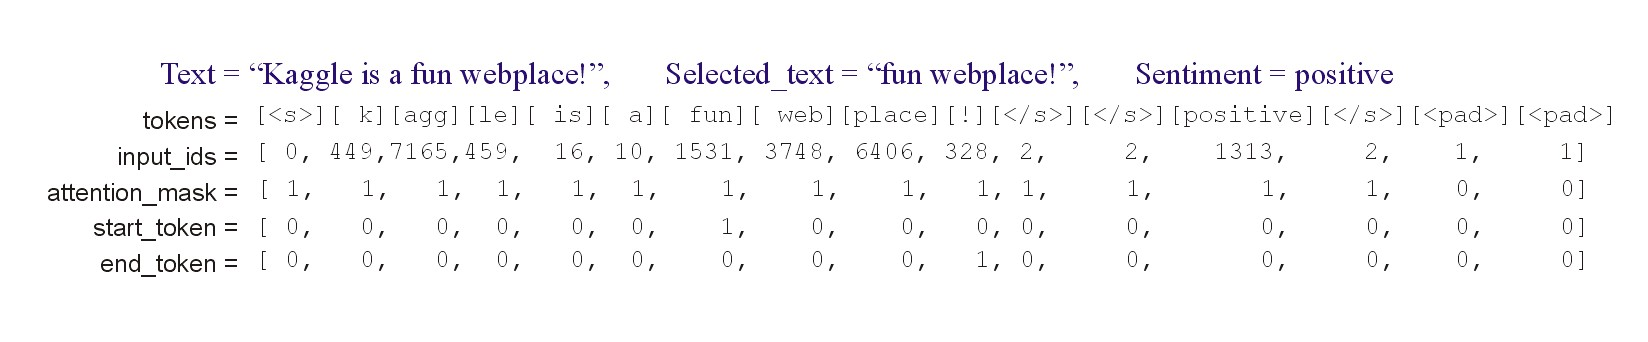

기존 BERT 는 token, segment embedding, positional embedding 등의 3가지에 대해서 input 을 받았는데 roberta 의 경우에는 token, attention_mask, start_token, end_token 의 형태로 인자를 받고 있는 것을 볼 수 있습니다. 

segment embedding 은 문장과 다음 문장에 대한 경계를 표시하기 위해서 사용했던 것이고, positional embedding 은 특정 위치의 토큰이 어떤 embedding 을 갖는지에 대해서 (512, 768) matrix 로 표현되었습니다. (주의! 틀릴확률이 매우 높습니다!) 이와 비슷하게 문장의 경계를 표시하기 위해서 `</s></s>` 를 사용하는 것으로 보이는데 positional 에 대한 정보를 딱히 주어지지 않는 것으로 보이네요.

In [101]:
# 저자와 좀 다르게 unique sentiment 에 대한 표기를 단순한 0,1,2 로 해보고자 합니다.
unique_sentiment = train.sentiment.unique()
print(unique_sentiment)
sentiment_id = collections.defaultdict(int)
for idx, sentiment in enumerate(unique_sentiment):
    sentiment_id[sentiment] = idx

['neutral' 'negative' 'positive']


아래 내용을 이해하기 쉽도록 과정을 표현해보도록 하겠습니다.
```
  Text  = "Kaggle is a fun webplace!", Selected_text="fun webplace!", Sentiment = positive
```

text1, text2 를 split 하고 " " 로 붙여줍니다. text1 은 시작에 space 를 넣어줍니다. <br>
```
  text1 = " Kaggle is a fun webplace!"
  text2 = "fun webplace!"
```

text1 에서 text2 의 위치(idx) 를 찾고, chars 배열을 만들어줍니다. enc 라는 변수는 text1 을 tokenizer 로 encode 한 것 입니다. 참고로 'Ġ' 는 space 라고 보입니다.
```
  idx = 3
  chars = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  enc.tokens = ['Ġk', 'agg', 'le', 'Ġis', 'Ġa', 'Ġfun', 'Ġweb', 'place', '!']
  enc.ids = [449, 7165, 459, 16, 10, 1531, 3748, 6406, 328]
```

실제 token 들의 (시작, 길이)를 가지는 offset 배열을 만들어줍니다. <br>
```
  offset = [(0, 2), (2, 5), (5, 7), (7, 10), (10, 12), (12, 16), (16, 20), (20, 25), (25, 26)]
```

text2 에서 text1 의 위치를 token 의 위치로 표시할 수 있는 tok 배열을 만들어줍니다.
```
  tok = [5,6,7,8]
```

그리고 위에서 구한 모든 정보를 통해서 그림에서 볼 수 있는 input 을 만들어준다!

In [84]:
shape0 = train.shape[0]
input_ids = np.ones((shape0,MAX_LEN),dtype='int32')
attention_mask = np.zeros((shape0,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((shape0,MAX_LEN),dtype='int32')
sentiment = np.zeros((shape0,3), dtype='int32') 

for k in range(train.shape[0]):
    # text2 의 위치를 찾아서 idx 로 정의하고, text2 위치에 1이라고 표시해주는 chars 배열을 생성합니다.
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1] == ' ': 
        chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # text1 에 대해서 특정 단어의 길이를 표기해주는 offsets 배열을 만들어줍니다. (단어의 시작, 단어의 끝)
    offsets = []
    idx = 0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # enc.ids 를 통해서 그림의 input_ids 를 만들어줍니다.
    # attention_mask 는 input_ids 의 길이만큼이기 때문에 해당 부분들을 1로 채워줍니다.
    input_ids[k,:len(enc.ids)+2] = [0] + enc.ids + [2]
    attention_mask[k,:len(enc.ids)+2] = 1
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    sentiment[k,s_tok] = 1

만들어진 데이터를 확인해봅니다.

In [85]:
target = 1042
print(input_ids[target,])
print(attention_mask[target,])
print(sentiment[target])

[    0   240   103    55  3838  6455  1569  1669    13    14     4   235
   122    24 12905    29    95    47     6     8   787  1215  1253   298
   922     2     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0]


# Build roBERTa Model

위에서 모델이 사용할 데이터를 만들었으니, 이제 모델을 만들어서 학습을 시켜봅니다.
config 파일을 이용해서 config 를 로딩하고, config 를 사용해서 reberta 모델을 로딩합니다.
bert_model 이 뽑아주는 output 은 x 인데, x 는 배열 형태로 들어옵니다. 

--- 
아래 부분은 확인이 필요합니다!

그 중 첫번째 아웃풋은 (MAX_LEN, 768) 크기의 아웃풋인데, 이것을 softmax 함수 형태로 (MAX_LEN,) 형태로 뽑아줍니다. 
Return 은 [transformers.BertModel](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel) 을 참고해보면 됩니다.
> A BaseModelOutputWithPoolingAndCrossAttentions (if return_dict=True is passed or when config.return_dict=True) or a tuple of torch.FloatTensor comprising various elements depending on the configuration (BertConfig) and inputs.

> last_hidden_state (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)) – Sequence of hidden-states at the output of the last layer of the model.

MAX_LEN 에 대해서 softmax 를 하기 때문에 x=sentiment 에 대한 확률 형태로 나타나게 됩니다. 
이 sentiment 에 대해서 crossentropy를 구하기 위해서 [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) 를 loss 로 설정해줍니다.

In [90]:
def build_roberta():
    # input 들을 받을 수 있도록 만듧니다.
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    
    # 기본적으로 transformers 안에 roberta 에 대한 설정 및 모듈들이 들어있습니다.
    # 자세한 내용은 [huggingface](https://huggingface.co/transformers/model_doc/roberta.html) 를 참고하면 좋을 것 같습니다.
    config = transformers.RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model=transformers.TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5', config=config)
    
    x = bert_model(ids, attention_mask=att, token_type_ids=tok)
    
    # x[0] 는 bert_model의 bert 의 첫번째 아웃풋으로 (batch_size, MAX_LEN, 768) 크기의 tensor 입니다.
    # 우리는 각 input token 에 대해서 해당 token 이 start 인지 아닌지를 표현하는 값들을 softmax 하여 나타냅니다.
    x = tf.keras.layers.Dropout(0.1)(x[0])
    x = tf.keras.layers.Conv1D(1,1)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(3)(x)
    x = tf.keras.layers.Activation('softmax')(x)

    # x = sentiment
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model

In [91]:
model = build_roberta()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 96)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model_4 (TFRobertaMo ((None, 96, 768), (N 124645632   input_12[0][0]                   
____________________________________________________________________________________________

# Train roBERTa Model

우리는 [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) 함수를 통해서 input_ids 를 총 5개로 나눌것입니다. StratifiedKFold 는 교차검증(cross-validation) 을 이용한 학습법입니다. 교차 유효성 검사 전략에 따라 데이터 집합을 생성하는데 사용할 수 있는 인덱스를 생성하는 도구입니다. 각각의 fold 에서 최고의 성능을 내는 모델을 사용해서 validation prediction 을 진행합니다.

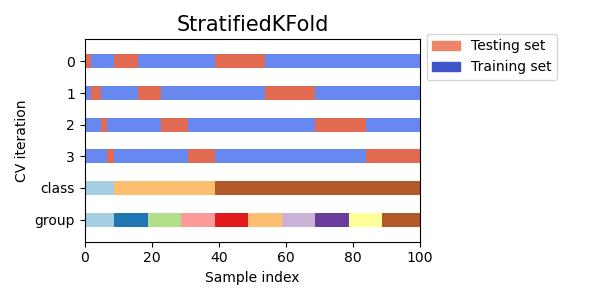

[참고](https://swlock.blogspot.com/2019/01/scikit-learn-cross-validation-iterators.html?m=1)

In [81]:
VER='v0'
DISPLAY=1

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
best_model = 0
history = []
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    tf.keras.backend.clear_session()
    model = build_roberta()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '/kaggle/working/%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
        
    history.append(model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [sentiment[idxT,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [sentiment[idxV,]])))
    
    print('Loading model...')
    model.load_weights('/kaggle/working/%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting validation...')
    sentiment[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    break

#########################
### FOLD 1
#########################
Train on 21984 samples, validate on 5496 samples
Epoch 1/3
21952/21984 [============================>.] - ETA: 0s - loss: 0.6767 - acc: 0.7118
Epoch 00001: val_loss improved from inf to 0.52076, saving model to /kaggle/working/v0-roberta-0.h5
21984/21984 [==============================] - 287s 13ms/sample - loss: 0.6764 - acc: 0.7119 - val_loss: 0.5208 - val_acc: 0.7804
Epoch 2/3
21984/21984 [==============================] - 249s 11ms/sample - loss: 0.4937 - acc: 0.8043


KeyboardInterrupt: 

# See train history


In [92]:
import matplotlib.pyplot as plt

plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

IndexError: list index out of range

# Submission

In [98]:
test0 = test.shape[0]
input_ids_t = np.ones((test0,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((test0,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((test0,MAX_LEN),dtype='int32')

for k in range(test0):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

In [100]:
import glob
saved_model = glob.glob('/kaggle/working/*.h5')

model = build_roberta()
model.load_weights(saved_model[0])

preds = np.zeros((input_ids_t.shape[0],3))

print('Predicting Test...')
preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)

Predicting Test...
3534/3534 [==============================] - 19s 5ms/sample


In [102]:
category_pred = [unique_sentiment[np.argmax(pred)] for pred in preds]

In [107]:
test['predicted_sentiment'] = category_pred
test[['textID','predicted_sentiment']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

,textID,text,sentiment,predicted_sentiment
2282,a17703215b,Having a cup of tea I have a cold so it`s tasting reall...,positive,positive
1428,cce4a3ca50,How was your chicken and chips?,neutral,neutral
1497,61c907173c,There you go.,neutral,neutral
2196,dd77d3f5cd,i know im wrong .. just give me one more chance sEnti ...,neutral,negative
1928,398d591255,haha i shaved all my facial hair off except for my mous...,neutral,neutral
2591,6e059414a2,"_Cake just little stomach bug, nothing serious",positive,neutral
3296,6397544955,Excellent then Chiang Mai is definitely a possible next...,positive,positive
941,b03e2a23e5,"_tdh Can you install ruby, gems and rails on keep? Please?",neutral,neutral
3438,4ca97418b7,oh that totally works too,positive,positive
3388,2bca22c7f3,"Yup, but what they going do??? He`s the Mother Effin Ch...",neutral,neutral


이 노트북과는 별개의 작업이 될 수 있겠지만, 다음으로 정리할 일은 다음과 같습니다.
* TPU 로 학습하는 방법에 대해서 써볼까 합니다.
* GPU 로 학습한 모델을 저장해볼까 합니다. 다음에 다시 쓸 수 있도록요.

계속 추가될 예정입니다. TO BE CONTINUED.
